# Coefficient of the estimator

For the data processing steps below refer to the empirical NB

In [30]:
# load libraries
#library(skimr)
library(tidyverse)
library(data.table)
require(parallel)
require(purrr)
require(gtools)
require('igraph')
require(gridExtra)
require(reshape2)
require(MASS)
require(Matrix)
patho <- "/home/diego/Documents/Thesis/MlayerSimul/"
source(paste0(patho,"scripts/DGPs.R"))
source(paste0(patho,"scripts/evalo.r"))
source(paste0(patho,"scripts/evalo2.r"))
source(paste0(patho,"scripts/makedata.R"))


# specify path
dpath  <-  "~/Dropbox/datatesis/gravfol"

#read data and filter  
data <- fread(paste0(dpath,"/mlayerdata.csv"))

data <- data  %>% dplyr::select(c(iso3num_o,
             iso3num_d,year,tourism,fdi,fdi2, contig:tradeflow_imf_d))  %>% 
             filter(year==2015)  %>% dplyr::select(-c(empire))

 data  <- data %>% mutate(
     across(c(tourism:tradeflow_imf_d), ~replace_na(.x, 0))
   )

data  <-  data %>% filter(!(is.na(iso3num_d) | is.na(iso3num_o) ))
#
    data  <- data  %>% 
    mutate(across(starts_with("tradeflow"), ~.x / 1000 ))

data <- data %>%  
    mutate(across(starts_with("tourism"), ~.x / 1000 ))

data <- data  %>% 
    mutate(across(starts_with("fdi"), ~ case_when( .x >  0 ~ .x / 1000000, T ~ 0 ))) 

data<- data %>% mutate( ldist = case_when( dist > 0 ~ log(dist/1000), T ~ 0 ))



## models

# model function

In [31]:
list1 <- c("ldist","contig","comlang_off","comcol","rta")
list2  <- c("tourism","fdi","tradeflow_comtrade_d")
strato <- list(c(1 ,2),c(1 ,3),c(2 ,1),
             c(3 ,1),c(2 ,3),c(3 ,2))

chosenito  <- ((250^2)*(249^2)*(3^2)*(2^2))/4



mljoch <- function(list1, list2, dato,str_list,ska, run=F){

lista  <- names(dato %>% dplyr::select(any_of(list1)))
listo  <-  names(dato %>% dplyr::select(any_of(list2)))
obja <- makedata(dato[,..listo],dato[,..lista],unlist(dato[,"iso3num_o"]),unlist(dato[,"iso3num_d"]))
init <- rep(-1,length(obja)-1)

if(run==T){
return( optim(init, fn = evalo, gr = evalo_g, method = "BFGS",
                simat = obja, strobject = str_list, 
                chosen=ska ))
} else{
return(evalo(init,obja,strato,chosenito))
}

}

#mljoch(list1,list2,data ,strato,chosenito,T)$par





#evalo_g(init,listerin,strato,250^2)



First use the model as indicated by jochman

In [33]:
list1 <- c("ldist","contig","comlang_off","comcol","rta")
list2  <- c("tourism","fdi","tradeflow_comtrade_d")
m0 <- mljoch(list1,list2,data ,strato,chosenito,T)
m0$par

[1]  2.410081  9.966761 20.336754 12.764897 15.697781

In [34]:
data  <- data %>% mutate(ldisq = ldist^2)
data  <- data %>% mutate(ldisc = ldist^3)
data  <- data %>% mutate(inter1 = ldist*contig)
data  <- data %>% mutate(inter2 = ldisq*contig)

list1 <- c("ldist","ldisq","contig","comlang_off","comcol")
list2  <- c("tourism","fdi","tradeflow_comtrade_d")
m1 <- mljoch(list1,list2,data ,strato,chosenito,T)

list1 <- c("ldist","ldisq","ldisc","contig","comlang_off","comcol")

m2 <- mljoch(list1,list2,data,strato,chosenito,T)


list1 <- c("ldist","ldisq","ldisc","contig","inter1","comlang_off","comcol")

m3 <- mljoch(list1,list2,data,strato,chosenito,T)


list1 <- c("ldist","ldisq","ldisc","contig","inter1","inter2","comlang_off","comcol")

m4 <- mljoch(list1,list2,data,strato,chosenito,T)



In [37]:
pars <- lapply(list(m1,m2,m3,m4), function(x){
    x$par
})

pars

[[1]]
[1]  -39.256438 1008.200762   97.078022   24.685332    6.337282

[[2]]
[1]  -52.32693 2309.38282  109.15339  379.16501  117.41565  377.10038

[[3]]
[1]  -51.57181 1745.65604  143.67995  196.28231 -182.52260   41.27922   22.54221

[[4]]
[1]  -51.42269 2091.63536 -181.23199   52.14250 -178.82837 -181.10854  103.69045
[8]  162.21986

# Centered data

In [35]:
data <- data %>%  mutate(sldata= ldist-mean(ldist),sldatasq= sldata^2)
data  <- data %>% mutate(inter1s = sldata*contig)
data  <- data %>% mutate(inter2s = sldatasq*contig)

list1 <- c("sldata","sldatasq","contig","comlang_off","comcol")

m5 <- mljoch(list1,list2,data ,strato,chosenito,T)

list1 <- c("sldata","sldatasq","contig","inter1","comlang_off","comcol")

m6 <- mljoch(list1,list2,data,strato,chosenito,T)


list1 <- c("sldata","sldatasq","contig","inter1","inter2","comlang_off","comcol")

m7 <- mljoch(list1,list2,data,strato,chosenito,T)

In [38]:
pars <- lapply(list(m1,m2,m3,m4,m5,m6,m7), function(x){
    x$par
})

pars

[[1]]
[1]  -39.256438 1008.200762   97.078022   24.685332    6.337282

[[2]]
[1]  -52.32693 2309.38282  109.15339  379.16501  117.41565  377.10038

[[3]]
[1]  -51.57181 1745.65604  143.67995  196.28231 -182.52260   41.27922   22.54221

[[4]]
[1]  -51.42269 2091.63536 -181.23199   52.14250 -178.82837 -181.10854  103.69045
[8]  162.21986

[[5]]
[1]  -9.172254 662.579936 145.947030  16.078016  12.096791

[[6]]
[1]  -8.598932 949.145862 491.210263 849.107911  14.648721  51.519408

[[7]]
[1]  -10.53645 1184.23429   49.00125  134.05466  -75.87506   29.77352   10.05425

# weigthed distance



In [42]:
data<- data %>% mutate( ldistw = case_when( distw > 0 ~ log(distw/1000), T ~ 0 ))
data  <- data %>% mutate(ldisqw = ldistw^2)
data  <- data %>% mutate(ldiscw = ldistw^3)
data  <- data %>% mutate(inter1w = ldistw*contig)
data  <- data %>% mutate(inter2w = ldisqw*contig)

list1 <- c("ldistw","contig","comlang_off","comcol")
mw0 <- mljoch(list1,list2,data ,strato,chosenito,T)

list1 <- c("ldistw","ldisqw","contig","comlang_off","comcol")
mw1 <- mljoch(list1,list2,data ,strato,chosenito,T)

list1 <- c("ldistw","ldisqw","ldiscw","contig","comlang_off","comcol")

mw2 <- mljoch(list1,list2,data,strato,chosenito,T)


list1 <- c("ldistw","ldisqw","ldiscw","contig","inter1w","comlang_off","comcol")

mw3 <- mljoch(list1,list2,data,strato,chosenito,T)


list1 <- c("ldistw","ldisqw","ldiscw","contig","inter1w","inter2w","comlang_off","comcol")

mw4 <- mljoch(list1,list2,data,strato,chosenito,T)

In [43]:
pars <- lapply(list(mw0,mw1,mw2,mw3,mw4), function(x){
    x$par
})

pars

[[1]]
[1]   0.9925496 118.9353116 174.2812800 229.0426001

[[2]]
[1]   47.83783 3656.68585   85.63612   14.58962   16.59305

[[3]]
[1]   57.19759 8721.03352 -184.64000   16.20692   42.33889   14.92258

[[4]]
[1]   51.96087 8025.89325 -424.76478 1656.75892 -596.90511  379.78472   50.71237

[[5]]
[1]    77.01259 15502.51808 -1133.29138    14.04903   -51.52143  -796.30233
[7]    39.63742   268.42030

# OECD

In [40]:
data_o <- data

oecd  <-  fread("~/Dropbox/datatesis/oecd_list.csv")
choecd  <- ((38^2)*(37^2)*(3^2)*(2^2))/4


data_o <- data_o %>% semi_join(oecd,by=c("iso3num_d"="iso3num")) %>% 
semi_join(oecd,by=c("iso3num_o"="iso3num"))

list1 <- c("sldata","sldatasq", "contig","comlang_off","comcol")
o1 <- mljoch(list1,list2,data_o ,strato,choecd,T)

list1 <- c("ldist","ldisq", "contig","comlang_off","comcol")
o2 <- mljoch(list1,list2,data_o ,strato,choecd,T)

In [41]:
pars <- lapply(list(o1,o2), function(x){
    x$par
})

pars

[[1]]
[1]  -978.59304 20494.43631   957.08187    21.58966   -31.50788

[[2]]
[1] -116.203484 9118.226702   15.378787  232.072923   -1.001545

In [44]:
sizo <- dim(data)[1]
set.seed(2020)
sdata <- data

best <- lapply(c(1:20) , function(i){

ese <-  sdata %>%  slice_sample(n=sizo, replace = T) %>%
        mutate(iso3num_o=data$iso3num_o,iso3num_d=data$iso3num_d)


list1 <- c("ldist","ldisq", "ldisc", "contig","comlang_off","comcol")
list2  <- c("tourism","fdi","tradeflow_comtrade_d")
mljoch(list1,list2,ese ,strato,chosenito,T)$par

})



      2.5%      97.5% 
-168.73891  -14.86116 
[1] -1.226155


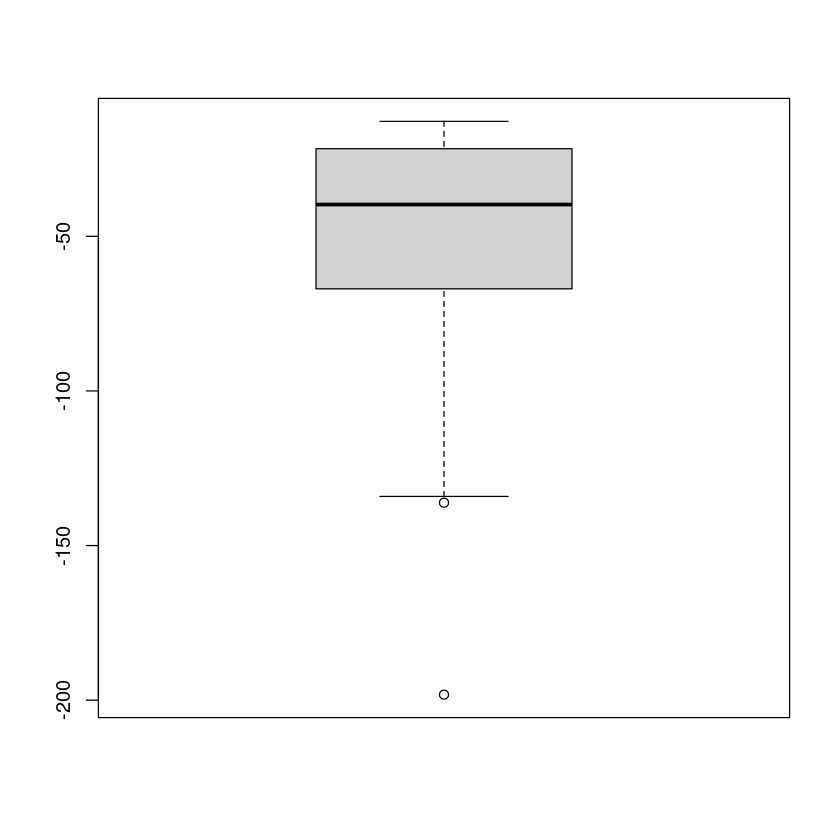

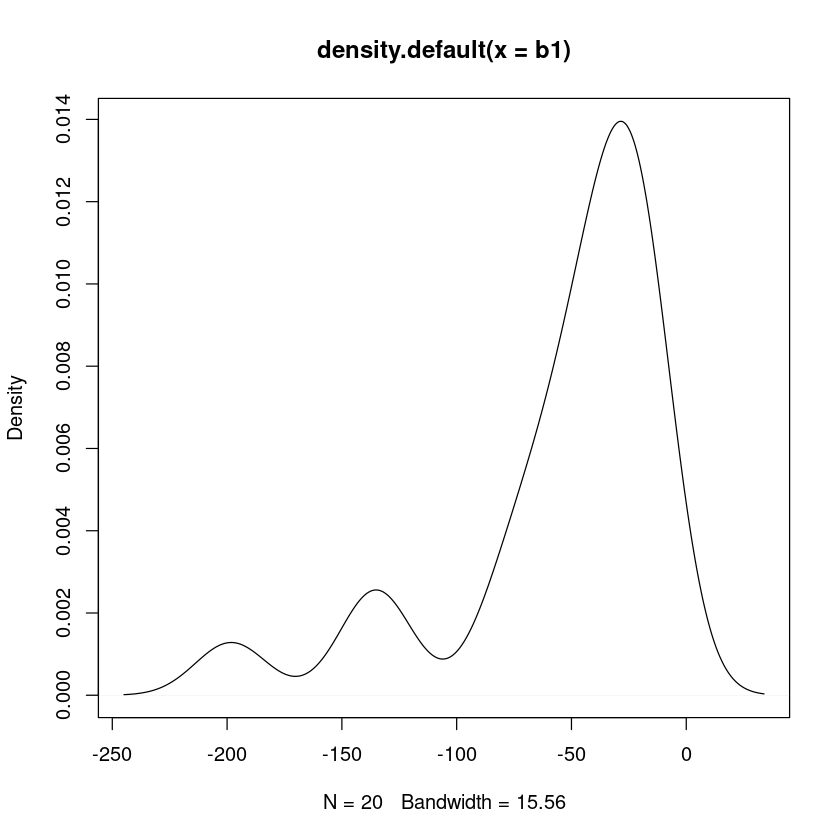

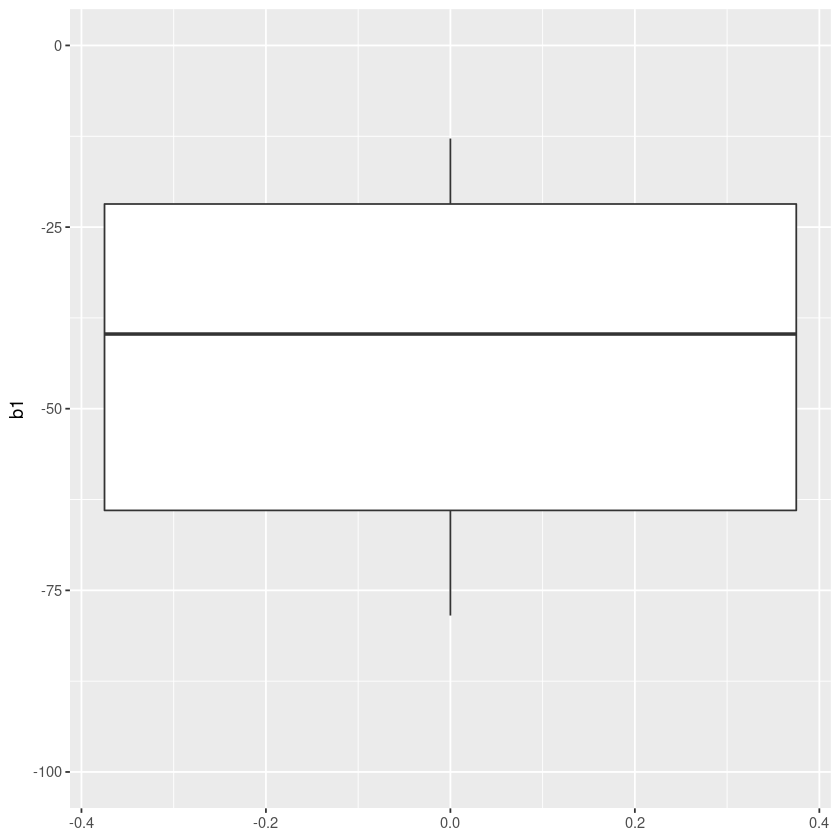

In [49]:
b1 <-lapply(best,function(x){
    x[1]
})

b1<-unlist(b1)

#skim(b1)

print(quantile(b1, c(0.025,0.975)))

print(sd(b1)/median(b1))


boxplot(b1)

plot(density(b1))

ggplot(as.data.frame(b1),aes(y=b1)) +
  geom_boxplot(outlier.shape = NA) + coord_cartesian(ylim=c(-100, 0))

In [23]:
sizo <- dim(data_o)[1]
set.seed(2020)
sdata <- data_o

choecd  <- ((38^2)*(3^2))

best <- lapply(c(1:100) , function(i){

ese <-  sdata %>%  slice_sample(n=sizo, replace = T) %>%
        mutate(iso3num_o=data_o$iso3num_o,iso3num_d=data_o$iso3num_d)


list1 <- c("ldist","ldisq", "ldisc","contig","comlang_off","comcol")
list2  <- c("tourism","fdi","tradeflow_comtrade_d")
mljoch(list1,list2,ese ,strato,choecd,T)$par

})



         5%         95% 
-0.32197886 -0.01663742 
[1] -0.4757878


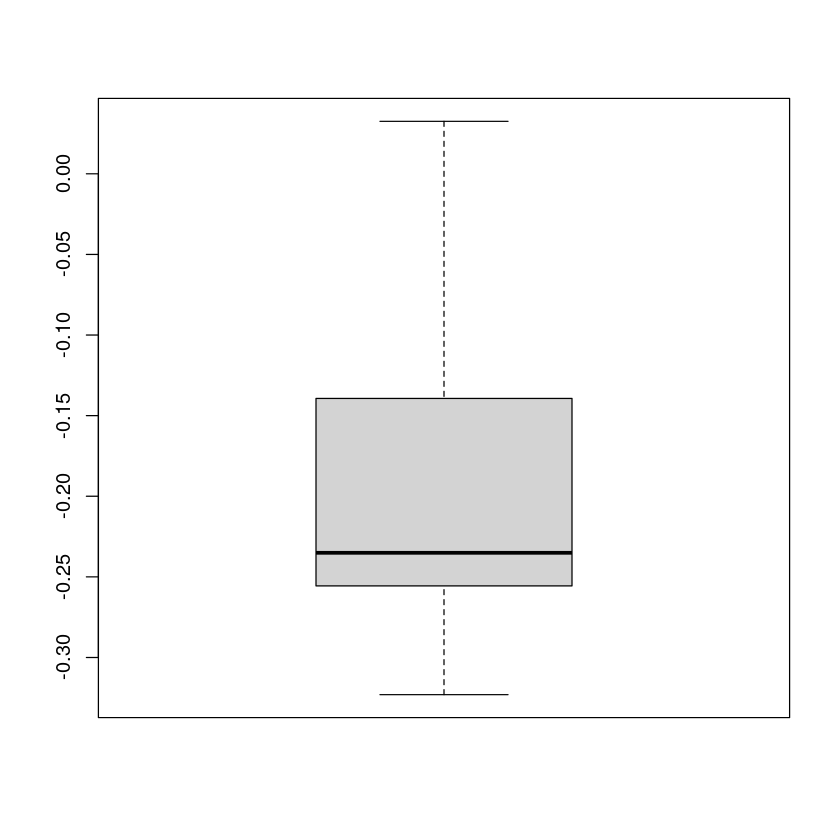

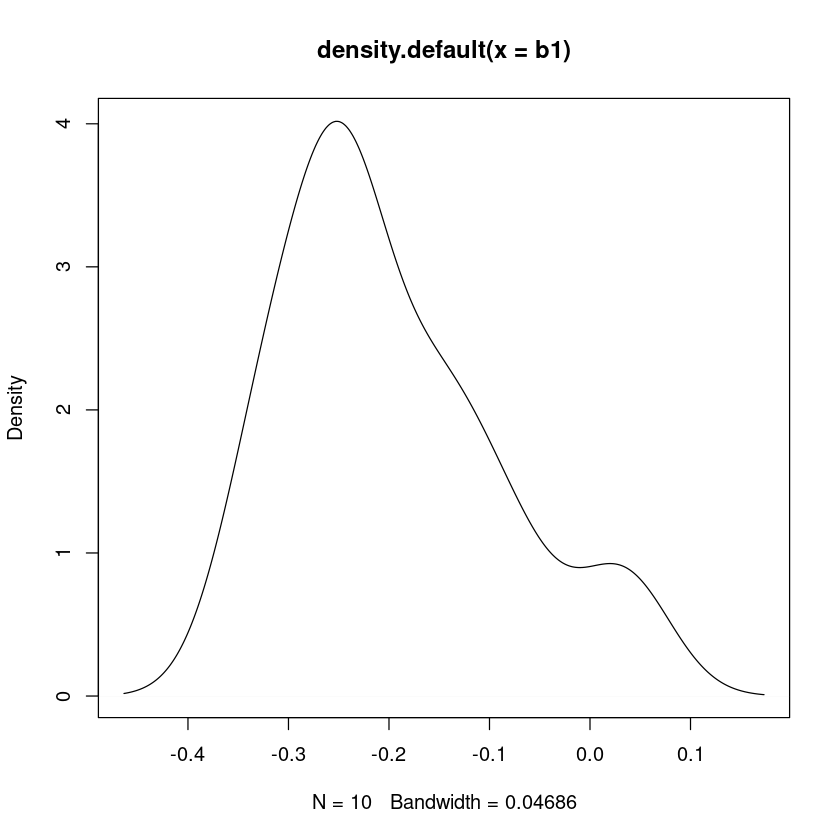

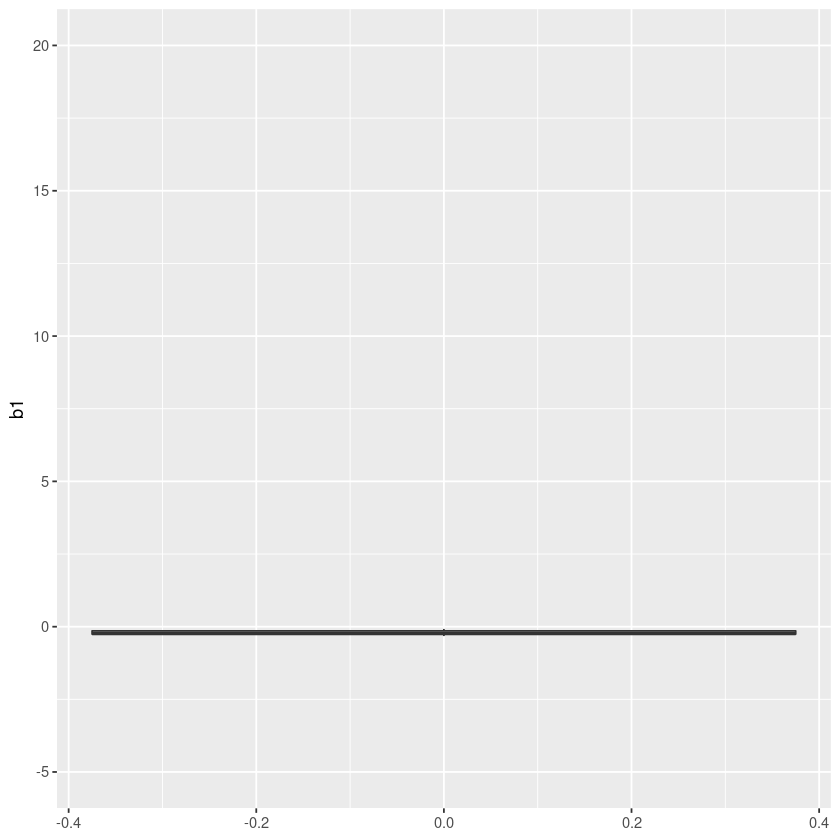

In [21]:
b1 <-lapply(best,function(x){
    x[1]
})

b1<-unlist(b1)

#skim(b1)

print(quantile(b1, c(0.05,0.95)))

print(sd(b1)/median(b1))


boxplot(b1)

plot(density(b1))

ggplot(as.data.frame(b1),aes(y=b1)) +
  geom_boxplot(outlier.shape = NA) + coord_cartesian(ylim=c(-5, 20))